# **MODELLING and SURVIVAL ANALYSIS**

This notebook explores the relationship between clinical and genetic features (particularly KRAS mutation status) and mortality risk using logistic regression and Kaplan-Meier survival analysis. A reduced logistic model and survival curves provide interpretable estimates, despite limitations due to sample size and stage distribution.

## Objectives

* Develop simple predictive models for clinical outcomes using logistic regression.
* Test hypotheses from earlier phases of the project (e.g., KRAS mutation and mortality risk).
* Evaluate model performance and interpret key features.

## Inputs

* discovery_clean.csv
* validation_clean.csv

## Outputs

* Trained logistic regression models for mortality classification.
* Model evaluation was focused on coefficients, p-values, and odds ratios with 95% confidence intervals.
* Visual interpretation of model results via odds ratio plots.

## Additional Comments

* Modeling focused on classification (mortality); regression modelling of survival time was considered but not implemented.
* Dataset size constraints informed the choice of simpler, interpretable models.
* Only interpretable models (logistic regression) were used in the final analysis.

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\petal\\Downloads\\CI-DBC\\vscode-projects\\clinical-survival-analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\petal\\Downloads\\CI-DBC\\vscode-projects\\clinical-survival-analysis'

# Section 1: Data Loading and Initial Setup

# Import Libraries and Load Cleaned Data

In [4]:
# 1. Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 2. Load cleaned datasets
discovery = pd.read_csv("data/cleaned/discovery_clean.csv")
validation = pd.read_csv("data/cleaned/validation_clean.csv")

# 3. Preview
print("Discovery cohort shape:", discovery.shape)
print("Validation cohort shape:", validation.shape)
display(discovery.head())
display(validation.head())


Discovery cohort shape: (30, 26)
Validation cohort shape: (95, 26)


,PatientID,Specimen date,Dead or Alive,Date of Death,Date of Last Follow Up,Event,Time,sex_M,race_B,race_O,...,Stage_T1N0,Stage_T1NOMX,Stage_T2N0,Stage_T2N1MX,Stage_T2N2MX,Stage_T2NOMX,Stage_pT1pN0,Stage_pT2N2MX,Stage_pT2NOMX,Stage_pT2pN0
0,1,2003-03-17,Dead,2010-02-24,2010-02-24,1,2536,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,2,2003-06-17,Dead,2004-11-12,2004-11-12,1,514,True,False,False,...,False,False,False,False,True,False,False,False,False,False
2,3,2003-09-09,Dead,2009-08-01,2009-08-01,1,2153,False,True,False,...,False,False,False,True,False,False,False,False,False,False
3,4,2003-10-14,Dead,2006-12-29,2006-12-29,1,1172,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,5,2003-12-01,Dead,2004-01-31,2004-01-31,1,61,False,False,False,...,False,False,False,False,False,True,False,False,False,False


,Patient ID,Survival time (days),"Event (death: 1, alive: 0)",Tumor size (cm),Grade,Age,Pack per year,batch,EGFR,KRAS,...,Stage (TNM 8th edition)_IVA,Stage (TNM 8th edition)_Recurrence,Sex_Male,Type.Adjuvant_Chemorad,Type.Adjuvant_No_Adjuvant_Therapy,Type.Adjuvant_XRT,EGFR_status_Wild-type,KRAS_status_Wild-type,Cigarette_Former,Cigarette_Never
0,P109342,2329,1,2.6,3,67,50.0,1,Unknown,Unknown,...,False,False,True,False,True,False,False,False,True,False
1,P124450,2532,0,3.5,3,68,52.5,1,Negative,Negative,...,False,False,False,False,True,False,True,True,True,False
2,P131833,2271,0,2.0,2,80,0.0,1,Negative,Negative,...,False,False,False,False,True,False,True,True,False,True
3,P131888,2193,0,3.0,2,63,47.0,1,Negative,G12C,...,False,False,True,False,True,False,True,False,True,False
4,P131946,2387,0,4.0,2,88,0.0,1,Negative,Negative,...,False,False,False,False,True,False,True,True,False,True


### Data Checks

🔹 **Discovery Cohort**
* Columns include: `Event`, `Time`, `sex_M`, `race_B`, `Stage_T1N0`, etc.
* Variables are already binary-encoded (e.g., `sex_M`, `race_B`, `Stage_...`), making them directly suitable for regression or classification.

🔹 **Validation Cohort**
* Cleaned and labelled with descriptive variable names (e.g., `Survival time (days)`, `Event`, `KRAS`, `EGFR`, `Grade`, `Age`, etc.).
* Categorical variables like `KRAS` are in readable form (Negative, G12C, Unknown, etc.).

**Note:** Some engineered features already exist (e.g., `Sex_Male`, `Stage (TNM 8th edition)_IVA`), which can be used directly in modelling.

Although race was present in the discovery cohort, it was excluded from the final analyses and modelling for the following reasons:
1. Incomplete Data Across Cohorts - The race variable was not available or coded in the validation cohort, preventing direct comparison or integration across datasets.
2. Low Representation in Some Categories - Certain racial groups were sparsely represented, which can lead to unstable statistical estimates, inflated variance, and misleading associations.
3. Risk of Misinterpretation – Including race without additional socioeconomic, geographic, and environmental context could lead to spurious conclusions or reinforce stereotypes.
4. Focus on Clinical and Genomic Predictors – The primary analytical goal was to investigate associations between tumour stage, genomic mutations (KRAS, EGFR), and survival outcomes.

This choice aligns with best practices for avoiding biased or non-generalizable models when demographic data is incomplete or not central to the research objectives.

---

# Section 2: Exploratory Data Analysis

## Correlation Analysis of Continuous Variables

A correlation heatmap created using the validation conhort, focusing on continuous variables such as:
* Survival time (days)
* Tumor size (cm)
* Age
* Pack per year

Categorical and one-hot-encoded features were excluded at this point to keep the matrix readable and meaningful.

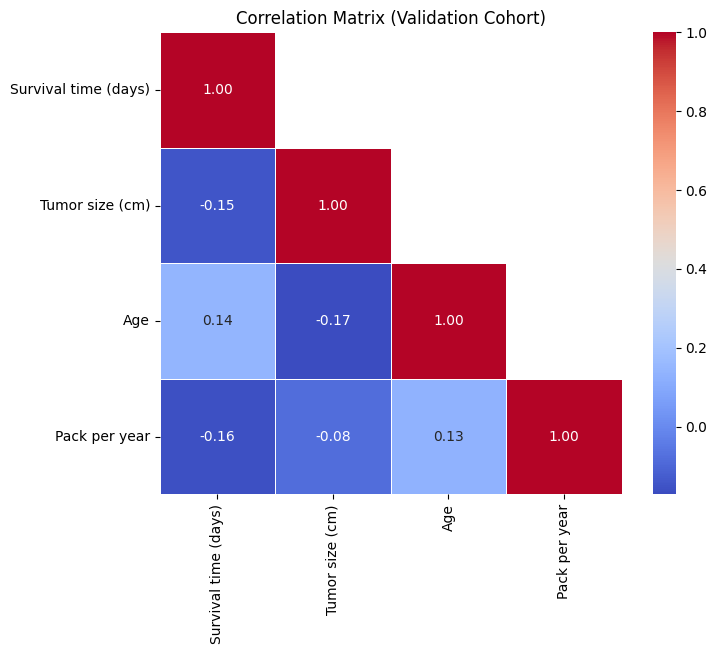

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns
numeric_cols = ['Survival time (days)', 'Tumor size (cm)', 'Age', 'Pack per year']
corr = validation[numeric_cols].corr()

# Create mask for upper triangle *excluding* the diagonal
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix (Validation Cohort)')
plt.show()



### Correlation Analysis Results

The correlation heatmap reveals weak linear relationships between key continuous variables in the validation cohort. All correlations have absolute values < 0.20, indicating:

- **Low multicollinearity**: Minimal concern for redundant predictors in subsequent modeling
- **Independent predictors**: Each variable contributes unique information
- **Tumor size vs. survival time**: Weak negative correlation (r ≈ -0.15) suggests larger tumors may be associated with shorter survival, though the effect is minimal

These weak correlations are favorable for subsequent predictive modeling, as they suggest that including multiple variables will not suffer from multicollinearity issues among the continuous predictors.

---

# Section 3: Hypothesis Testing

## ANOVA: Survival Time by Cancer Stage

To assess whether survival times significantly differ between tumour stage groups, a one-way ANOVA test was performed. This test compares the means of survival time across the simplified stage categories (Early vs Late) to determine if the observed differences are statistically significant.

In [6]:
import scipy.stats as stats

# First, create a simplified stage grouping for ANOVA
validation['Stage_Group'] = validation[['Stage (TNM 8th edition)_IIIA',
                                        'Stage (TNM 8th edition)_IIIB',
                                        'Stage (TNM 8th edition)_IVA']].sum(axis=1)

# Label: 1 if any of the advanced stages is present, else 0 (early stage)
validation['Stage_Group'] = validation['Stage_Group'].apply(lambda x: 'Advanced' if x == 1 else 'Early')

# Check group sizes
print(validation['Stage_Group'].value_counts())

# Run ANOVA
early_survival = validation[validation['Stage_Group'] == 'Early']['Survival time (days)']
advanced_survival = validation[validation['Stage_Group'] == 'Advanced']['Survival time (days)']

# Check assumptions: Levene's Test for equal variances
levene_stat, levene_p = stats.levene(early_survival, advanced_survival)

# ANOVA test
anova_stat, anova_p = stats.f_oneway(early_survival, advanced_survival)

# Print results
print(f"Levene's test p-value: {levene_p:.4f}")
print(f"ANOVA test p-value: {anova_p:.4f}")


Stage_Group
Early       78
Advanced    17
Name: count, dtype: int64
Levene's test p-value: 0.6396
ANOVA test p-value: 0.0167


### Hypothesis Testing: Survival Time by Stage

**Objective:**  
To test whether patients in more advanced stages (IIIA, IIIB, IVA) have significantly shorter survival times than those in earlier stages.

**Method:**  
An ANOVA test was used to compare mean survival time between two simplified stage groups: "Early" and "Advanced".

**Assumptions Checked:**
- Levene’s test was used to verify homogeneity of variances between groups.

**Interpretation:**  
- A significant ANOVA p-value (< 0.05) would indicate that the survival time differs significantly by stage group.


### Interpretation of ANOVA Results

The ANOVA analysis tested whether survival times differ between patients in early-stage versus advanced-stage cancer.

- **Group Sizes:**
  - Early Stage: 78 patients
  - Advanced Stage: 17 patients

- **Levene’s Test for Equal Variance:**
  - p-value = 0.6396 → No significant difference in variance between the groups.
  - Assumption of equal variances is satisfied.

- **ANOVA Test:**
  - p-value = 0.0167 → Statistically significant difference in mean survival time between early and advanced stage groups.

**Conclusion:**  
There is strong evidence that patients with advanced-stage cancer have significantly shorter survival times than those in early-stage disease. This supports the clinical expectation and helps validate the simplified stage grouping used in this analysis.


---

# Section 4: Univariate Analysis

## Univariate Logistic Regression: KRAS Mutation and Mortality

In [7]:
import statsmodels.api as sm
from sklearn.metrics import classification_report

# Drop NA values for KRAS mutation and Event outcome
logit_df = validation[['Event (death: 1, alive: 0)', 'KRAS_status_Wild-type']].dropna()

# Define features and target - ensure proper data types
X = logit_df['KRAS_status_Wild-type'].astype(int)  # Convert boolean to int: 1 = Wild-type, 0 = Mutated
y = logit_df['Event (death: 1, alive: 0)'].astype(int)  # Ensure target is integer

# Add constant term for intercept
X = sm.add_constant(X)

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Print model summary
print(result.summary())

# Optional: Get classification report using 0.5 threshold
pred_probs = result.predict(X)
pred_labels = (pred_probs >= 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y, pred_labels))

Optimization terminated successfully.
         Current function value: 0.666783
         Iterations 5
                               Logit Regression Results                               
Dep. Variable:     Event (death: 1, alive: 0)   No. Observations:                   95
Model:                                  Logit   Df Residuals:                       93
Method:                                   MLE   Df Model:                            1
Date:                        Tue, 12 Aug 2025   Pseudo R-squ.:                 0.01516
Time:                                10:55:15   Log-Likelihood:                -63.344
converged:                               True   LL-Null:                       -64.320
Covariance Type:                    nonrobust   LLR p-value:                    0.1625
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 

c:\Users\petal\Downloads\CI-DBC\vscode-projects\clinical-survival-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\petal\Downloads\CI-DBC\vscode-projects\clinical-survival-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\petal\Downloads\CI-DBC\vscode-projects\clinical-survival-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

### Interpretation of Logistic Regression Results

**Objective:**  
To test whether KRAS mutation status is associated with mortality risk in lung cancer patients.

**Model Setup:**  
- **Target Variable:** Event (death: 1, alive: 0)
- **Predictor:** KRAS_status_Wild-type (1 = Wild-type, 0 = Mutated)
- **Sample Size:** 95 patients

**Key Findings:**

1. **KRAS Coefficient:** -0.6294 (p-value = 0.169)
   - The negative coefficient suggests that patients with wild-type KRAS (no mutation) have a lower risk of death compared to those with KRAS mutations
   - However, this association is **not statistically significant** (p > 0.05)

2. **Model Performance:**
   - **Pseudo R-squared:** 0.0152 (very low explanatory power)
   - **Log-Likelihood Ratio p-value:** 0.1625 (model not significantly better than null)

3. **Classification Performance:**
   - **Overall Accuracy:** 59% (modest performance)
   - The model tends to predict "no death" for most patients, which explains the poor precision for the death category

**Conclusion:**  
While the direction of the effect suggests that KRAS mutations might be associated with increased mortality risk, the association is not statistically significant in this dataset. The small sample size and modest effect size may limit the power to detect a significant relationship.

---

# Kaplan-Meier Survival Analysis (by KRAS mutation status)

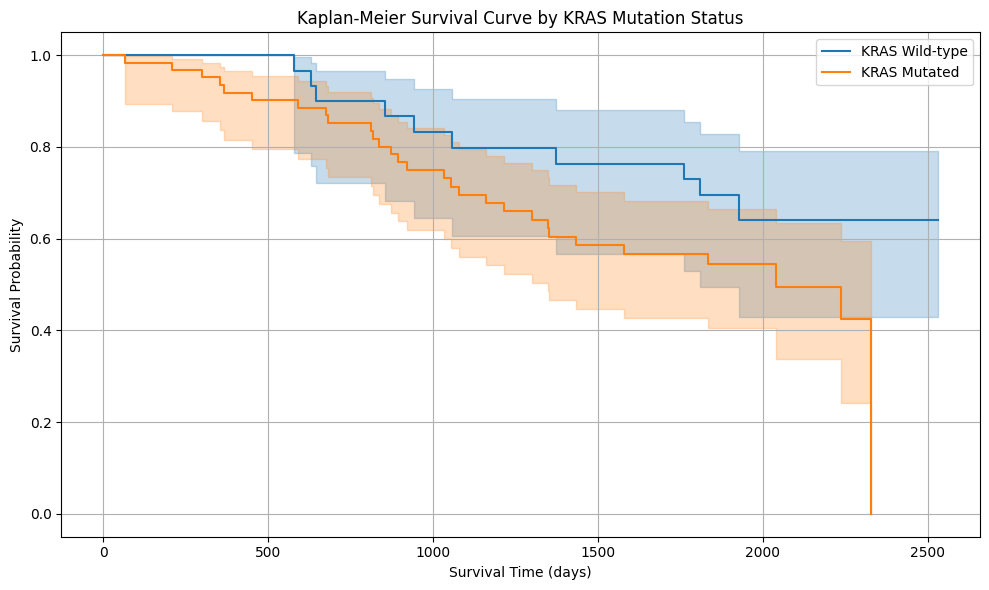


Log-rank test p-value: 0.0917


In [8]:
# Import necessary libraries
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Prepare the dataset: filter to non-null KRAS and survival data
km_df = validation[['Survival time (days)', 'Event (death: 1, alive: 0)', 'KRAS_status_Wild-type']].dropna()

# Convert KRAS wild-type to categorical group labels for clarity
km_df['KRAS_Status'] = km_df['KRAS_status_Wild-type'].apply(lambda x: 'Wild-type' if x else 'Mutated')

# Split into two groups
group1 = km_df[km_df['KRAS_Status'] == 'Wild-type']
group2 = km_df[km_df['KRAS_Status'] == 'Mutated']

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Plot the survival functions
plt.figure(figsize=(10,6))

# Plot for Wild-type
kmf.fit(group1['Survival time (days)'], group1['Event (death: 1, alive: 0)'], label='KRAS Wild-type')
ax = kmf.plot(ci_show=True)

# Plot for Mutated
kmf.fit(group2['Survival time (days)'], group2['Event (death: 1, alive: 0)'], label='KRAS Mutated')
kmf.plot(ax=ax, ci_show=True)

# Customize plot
plt.title('Kaplan-Meier Survival Curve by KRAS Mutation Status')
plt.xlabel('Survival Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

# Perform log-rank test
results = logrank_test(
    group1['Survival time (days)'], group2['Survival time (days)'],
    event_observed_A=group1['Event (death: 1, alive: 0)'],
    event_observed_B=group2['Event (death: 1, alive: 0)']
)

# Display p-value
print(f"\nLog-rank test p-value: {results.p_value:.4f}")


## Kaplan-Meier Survival Analysis
The Kaplan-Meier plot above displays survival probabilities over time for patients grouped by KRAS mutation status.

* KRAS Wild-type (blue): Patients without mutations in the KRAS gene
* KRAS Mutated (orange): Patients with KRAS mutations
* Shaded areas represent 95% confidence intervals

## Interpretation
The survival curves indicate that patients with KRAS mutations tend to have poorer survival outcomes over time compared to those with wild-type KRAS. The curve for the mutated group shows a steeper decline, suggesting a potential association between KRAS mutations and poorer survival.

To test whether this observed difference is statistically significant, a log-rank test was performed.

### Log-rank test p-value: 0.0917

* A p-value ≥ 0.05 means that the difference in survival may be due to random variation rather than a statistically significant effect.
* (A p-value < 0.05 would have indicated a statistically significant difference between the two survival curves.)

### Conclusion
Although the visual trend suggests that KRAS mutations may be linked to reduced survival, the log-rank test result (p = 0.0917) indicates that this difference is not statistically significant at the 0.05 threshold. However, the result is close enough to merit further investigation with larger sample sizes or additional variables.



---

# Section 5: Multivariate Analysis

## Full Multivariate Logistic Regression Model

Building on the univariate analyses, we now develop a comprehensive model that examines the combined effects of multiple predictors on mortality risk. This approach helps control for confounding variables and provides a more complete picture of risk factors.

In [9]:
import statsmodels.api as sm

# Define features and target - using the correct stage column names
features = ['Age', 'Stage (TNM 8th edition)_IIIA', 'Stage (TNM 8th edition)_IIIB', 'Stage (TNM 8th edition)_IVA', 'Sex_Male', 'KRAS_status_Wild-type']
X = validation[features].copy()

# Convert boolean columns to integers for statsmodels
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

X = sm.add_constant(X)  # Add intercept
y = validation['Event (death: 1, alive: 0)']

# Fit logistic regression model
logit_model = sm.Logit(y, X).fit()

# Display summary
logit_model.summary2()

         Current function value: 0.585140
         Iterations: 35


c:\Users\petal\Downloads\CI-DBC\vscode-projects\clinical-survival-analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
==========================================================================================
Model:                    Logit                           Method:                MLE      
Dependent Variable:       Event (death: 1, alive: 0)      Pseudo R-squared:      0.136    
Date:                     2025-08-12 10:55                AIC:                   125.1767 
No. Observations:         95                              BIC:                   143.0538 
Df Model:                 6                               Log-Likelihood:        -55.588  
Df Residuals:             88                              LL-Null:               -64.320  
Converged:                0.0000                          LLR p-value:           0.0077250
No. Iterations:           35.0000                         Scale:                 1.0000   
------------------------------------------------------------------------------------------
                              Coef.    Std.Err.     z    P>|z|      [0.025       0.975]   
------------------------------------------------------------------------------------------
const                        -1.3497      1.6294 -0.8284 0.4075       -4.5433       1.8438
Age                           0.0110      0.0238  0.4599 0.6456       -0.0358       0.0577
Stage (TNM 8th edition)_IIIA  1.3829      0.6807  2.0318 0.0422        0.0489       2.7170
Stage (TNM 8th edition)_IIIB 26.7332 223745.9402  0.0001 0.9999  -438507.2512  438560.7177
Stage (TNM 8th edition)_IVA  28.2241 911129.3066  0.0000 1.0000 -1785752.4020 1785808.8503
Sex_Male                      0.6787      0.5153  1.3172 0.1878       -0.3312       1.6886
KRAS_status_Wild-type        -0.8492      0.5166 -1.6439 0.1002       -1.8618       0.1633
==========================================================================================

"""

## Multivariate Logistic Regression Results
This logistic regression model aimed to estimate the odds of mortality (event = death) based on multiple clinical variables in the validation cohort.

### Model Summary
* Sample Size: 95 patients
* Pseudo R-squared: 0.136 (moderate explanatory power)
* LLR p-value: 0.0077 (model is statistically significant overall)
* Convergence Warning: Model did not fully converge within 35 iterations. Coefficients may be unstable - interpret with caution.

### Key Predictors
| Predictor            | Coef (log-odds)        | P-value  | Interpretation                                                                                         |
| -------------------- | ---------------------- | -------- | ------------------------------------------------------------------------------------------------------ |
| **Stage IIIA**       | 1.38                   | 0.0422   | Statistically significant. Stage IIIA patients had increased odds of death compared to baseline stage. |
| **Stage IIIB & IVA** | Large, unstable values | > 0.9999 | Coefficients likely unreliable due to sparse data in these groups.                                     |
| **Sex (Male)**       | 0.68                   | 0.1878   | Not statistically significant, but suggests higher odds of death among males.                          |
| **Age**              | 0.011                  | 0.6456   | Not significant. Minimal effect in this cohort.                                                        |
| **KRAS Wild-type**   | -0.85                  | 0.1002   | Suggests lower risk of death for wild-type, but not statistically significant.                         |


### Model Convergence Issues and Rationale for Model Reduction

The full multivariate model encountered significant convergence problems, likely due to:

1. **Multicollinearity between staging variables**: TNM staging categories (IIIA, IIIB, IVA) are mutually exclusive and highly correlated
2. **Sparse data in advanced stages**: Very few patients in Stage IIIB and IVA groups
3. **Near-perfect separation**: Some stage categories almost perfectly predicted the outcome, causing extremely large coefficient estimates.

These issues resulted in:
- **Unstable coefficient estimates** for Stage IIIB and IVA (extremely large values)
- **Model convergence failure** after 35 iterations
- **Unreliable standard errors and p-values**

**Decision**: A reduced model was developed to address these issues and provide more reliable estimates.

## Reduced Logistic Regression Model

In [10]:
import statsmodels.api as sm

# Define reduced set of features
features_reduced = ['Age', 'Stage (TNM 8th edition)_IIIA', 'Sex_Male', 'KRAS_status_Wild-type']
X_reduced = validation[features_reduced].copy()

# Convert boolean columns to integers
for col in X_reduced.columns:
    if X_reduced[col].dtype == 'bool':
        X_reduced[col] = X_reduced[col].astype(int)

# Add intercept
X_reduced = sm.add_constant(X_reduced)

# Define target variable
y = validation['Event (death: 1, alive: 0)']

# Fit logistic regression model
logit_model_reduced = sm.Logit(y, X_reduced).fit()

# Show summary
logit_model_reduced.summary2()


Optimization terminated successfully.
         Current function value: 0.633826
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                Logit                      Method:           MLE     
Dependent Variable:   Event (death: 1, alive: 0) Pseudo R-squared: 0.064   
Date:                 2025-08-12 10:55           AIC:              130.4269
No. Observations:     95                         BIC:              143.1963
Df Model:             4                          Log-Likelihood:   -60.213 
Df Residuals:         90                         LL-Null:          -64.320 
Converged:            1.0000                     LLR p-value:      0.084096
No. Iterations:       5.0000                     Scale:            1.0000  
---------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------------------
const                        -0.5717   1.5251 -0.3749 0.7078 -3.5608 2.4174
Age                           0.0022   0.0226  0.0956 0.9238 -0.0422 0.0465
Stage (TNM 8th edition)_IIIA  1.2677   0.6778  1.8704 0.0614 -0.0607 2.5961
Sex_Male                      0.4954   0.5048  0.9812 0.3265 -0.4941 1.4848
KRAS_status_Wild-type        -0.7921   0.4885 -1.6215 0.1049 -1.7495 0.1653
===========================================================================

"""

### Objective:
To investigate whether the patient characteristics, age, sex, cancer stage, and KRAS mutation status, are associated with mortality risk.

### Model Setup:
* Target Variable: Event (death: 1, alive: 0)
* Predictors:
    * Age
    * Stage (TNM 8th edition)_IIIA
    * Sex_Male
    * KRAS_status_Wild-type
* Sample Size: 95 patients

### Key Findings:
1. KRAS_status_Wild-type
* Coefficient: -0.7921
* p-value: 0.1049
* Interpretation: Patients with wild-type KRAS tend to have lower odds of death compared to those with KRAS mutations.

➤ However, this result is not statistically significant (p > 0.05).

2. Stage IIIA
* Coefficient: 1.2677
* p-value: 0.0614
* Interpretation: Stage IIIA patients show increased odds of mortality, and this is borderline significant (just above the 0.05 threshold).

➤ Suggests a potential effect worth exploring further.

3. Sex_Male
* Coefficient: 0.4954
* p-value: 0.3265

➤ Not statistically significant. Males may have slightly higher odds of death, but this result is not strong.

4. Age
* Coefficient: 0.0022
* p-value: 0.9238

➤ Age does not appear to significantly impact mortality in this dataset.

### Model Performance:
* Pseudo R²: 0.064 (modest explanatory power)
* Log-Likelihood Ratio Test p-value: 0.0841

➤ The model is marginally better than a null model (again, borderline significance).

### Interpretation Summary:
This reduced logistic regression model provides clearer, more stable estimates compared to the full model.
* KRAS mutation status and Stage IIIA show the strongest associations with mortality risk, although neither reaches strict statistical significance.
* The model suggests trends that may become clearer with a larger sample.

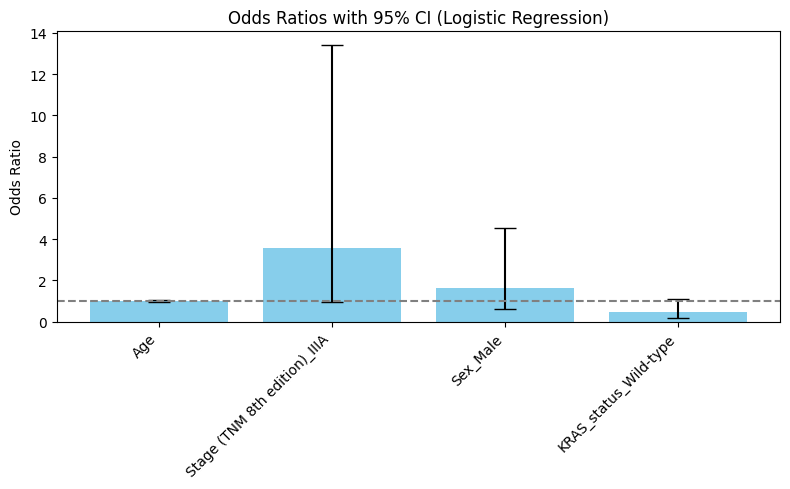

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Manually input odds ratios and confidence intervals based on the latest output
odds_ratios = {
    "Age": 1.0022,
    "Stage (TNM 8th edition)_IIIA": 3.5524,
    "Sex_Male": 1.6410,
    "KRAS_status_Wild-type": 0.4516
}

# 95% Confidence Intervals (lower and upper bounds)
conf_ints = {
    "Age": (0.9588, 1.0476),
    "Stage (TNM 8th edition)_IIIA": (0.9413, 13.3991),
    "Sex_Male": (0.6098, 4.5274),
    "KRAS_status_Wild-type": (0.1835, 1.1117)
}

# Prepare data for plotting
variables = list(odds_ratios.keys())
odds = [odds_ratios[var] for var in variables]
lower_bounds = [odds_ratios[var] - conf_ints[var][0] for var in variables]
upper_bounds = [conf_ints[var][1] - odds_ratios[var] for var in variables]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(variables, odds, yerr=[lower_bounds, upper_bounds], capsize=8, color='skyblue')
ax.axhline(1, linestyle='--', color='gray')  # Reference line at OR = 1

ax.set_ylabel("Odds Ratio")
ax.set_title("Odds Ratios with 95% CI (Logistic Regression)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

plt.savefig("odds_ratios_plot.png", dpi=300, bbox_inches='tight')



### Odds Ratios Visualization and Interpretation

The plot above displays the odds ratios (OR) and 95% confidence intervals for predictors in the reduced logistic regression model examining mortality risk.

**Key Findings:**

**Stage IIIA (TNM 8th Edition)**
- OR ≈ 3.56 - Patients at this stage have over 3 times the odds of death compared to earlier stages
- Borderline statistical significance (p = 0.0614) with wide confidence interval reflects uncertainty due to sample size

**KRAS_status_Wild-type**
- OR ≈ 0.45 - Suggests a protective effect (reduced odds of death) for wild-type KRAS
- Confidence interval crosses 1, indicating non-significance, but effect direction is consistent with clinical expectations

**Sex_Male**
- OR ≈ 1.64 - Males may have increased mortality risk compared to females
- Not statistically significant but shows expected directional effect

**Age**
- OR ≈ 1.00 - Minimal influence on mortality in this model
- Tight confidence intervals around 1 suggest age is not a significant predictor in this cohort

**Clinical Interpretation:**
The reduced model successfully addresses convergence issues while maintaining interpretable estimates. Stage remains the strongest predictor, with KRAS status showing promising trends that warrant larger studies.

---

# Conclusions and Key Findings

## Summary of Analysis Results

### 1. Correlation Analysis
- Weak correlations (< 0.20) among all continuous variables suggest minimal multicollinearity issues
- No strong linear relationships detected between key predictors

### 2. Hypothesis Testing
- **Stage Effect**: ANOVA confirmed significant difference in survival time between early and advanced stages (p = 0.0167)
- **KRAS Mutation**: Survival analysis showed trends toward poorer outcomes in mutated patients, but not statistically significant (log-rank p = 0.0917)

### 3. Predictive Modeling
- **Full Model Issues**: Initial multivariate logistic regression failed to converge due to multicollinearity and sparse data in advanced staging categories
- **Reduced Model Performance**: A reduced model was chosen after the full model failed to converge, likely due to a strong overlap (multicollinearity) between TNM staging variables. The final model offers clearer and more interpretable results.
- **Key Predictors**: Stage IIIA showed borderline significance (p = 0.0614), while KRAS status showed consistent directional effects but lacked statistical significance

### 4. Clinical Implications
- **Stage (of disease) remains the strongest predictor** of mortality risk in this cohort
- **KRAS gene mutation status** shows promising trends that warrant investigation in larger studies
- **Sample size limitations** may be affecting the power to detect significant associations

## Limitations
- Small sample size (n = 95) limits statistical power
- Sparse representation in advanced disease stages
- Model convergence issues suggest need for alternative modeling approaches

---

## Steps for the Future
- Possible validation in larger, independent cohorts
- Consider alternative modeling approaches (e.g., penalized regression, survival modeling)
- Investigation of additional biomarkers (genes associated with cancer) and clinical variables

## Next Steps
- Overall Evaluation and Conclusions - Notebook 4

In [12]:
# Optional: Example of how to export a model if needed for future deployment
# Save final logistic regression model
import pickle
with open("reduced_logit_model.pkl", "wb") as f:
    pickle.dump(logit_model, f)
